In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle

! pip install openpyxl

In [27]:
all_df = pd.read_excel('Real_estate_valuation_data_set.xlsx',index_col=False)
all_df = shuffle(all_df)
all_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
203,204,2012.666667,15.6,289.3248,5,24.98203,121.54348,46.1
173,174,2013.083333,41.3,401.8807,4,24.98326,121.54460,35.1
296,297,2012.750000,12.5,1144.4360,4,24.99176,121.53456,34.1
179,180,2013.083333,14.0,438.8513,1,24.97493,121.52730,42.6
402,403,2012.833333,12.7,187.4823,1,24.97388,121.52981,28.5
...,...,...,...,...,...,...,...,...
384,385,2012.750000,16.1,4066.5870,0,24.94297,121.50342,12.9
227,228,2012.916667,32.4,265.0609,8,24.98059,121.53986,40.2
6,7,2012.666667,34.5,623.4731,7,24.97933,121.53642,40.3
324,325,2012.666667,12.4,1712.6320,2,24.96412,121.51670,31.3


In [28]:
all_df.info()
all_df = all_df.drop("No",axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 203 to 171
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 29.1 KB


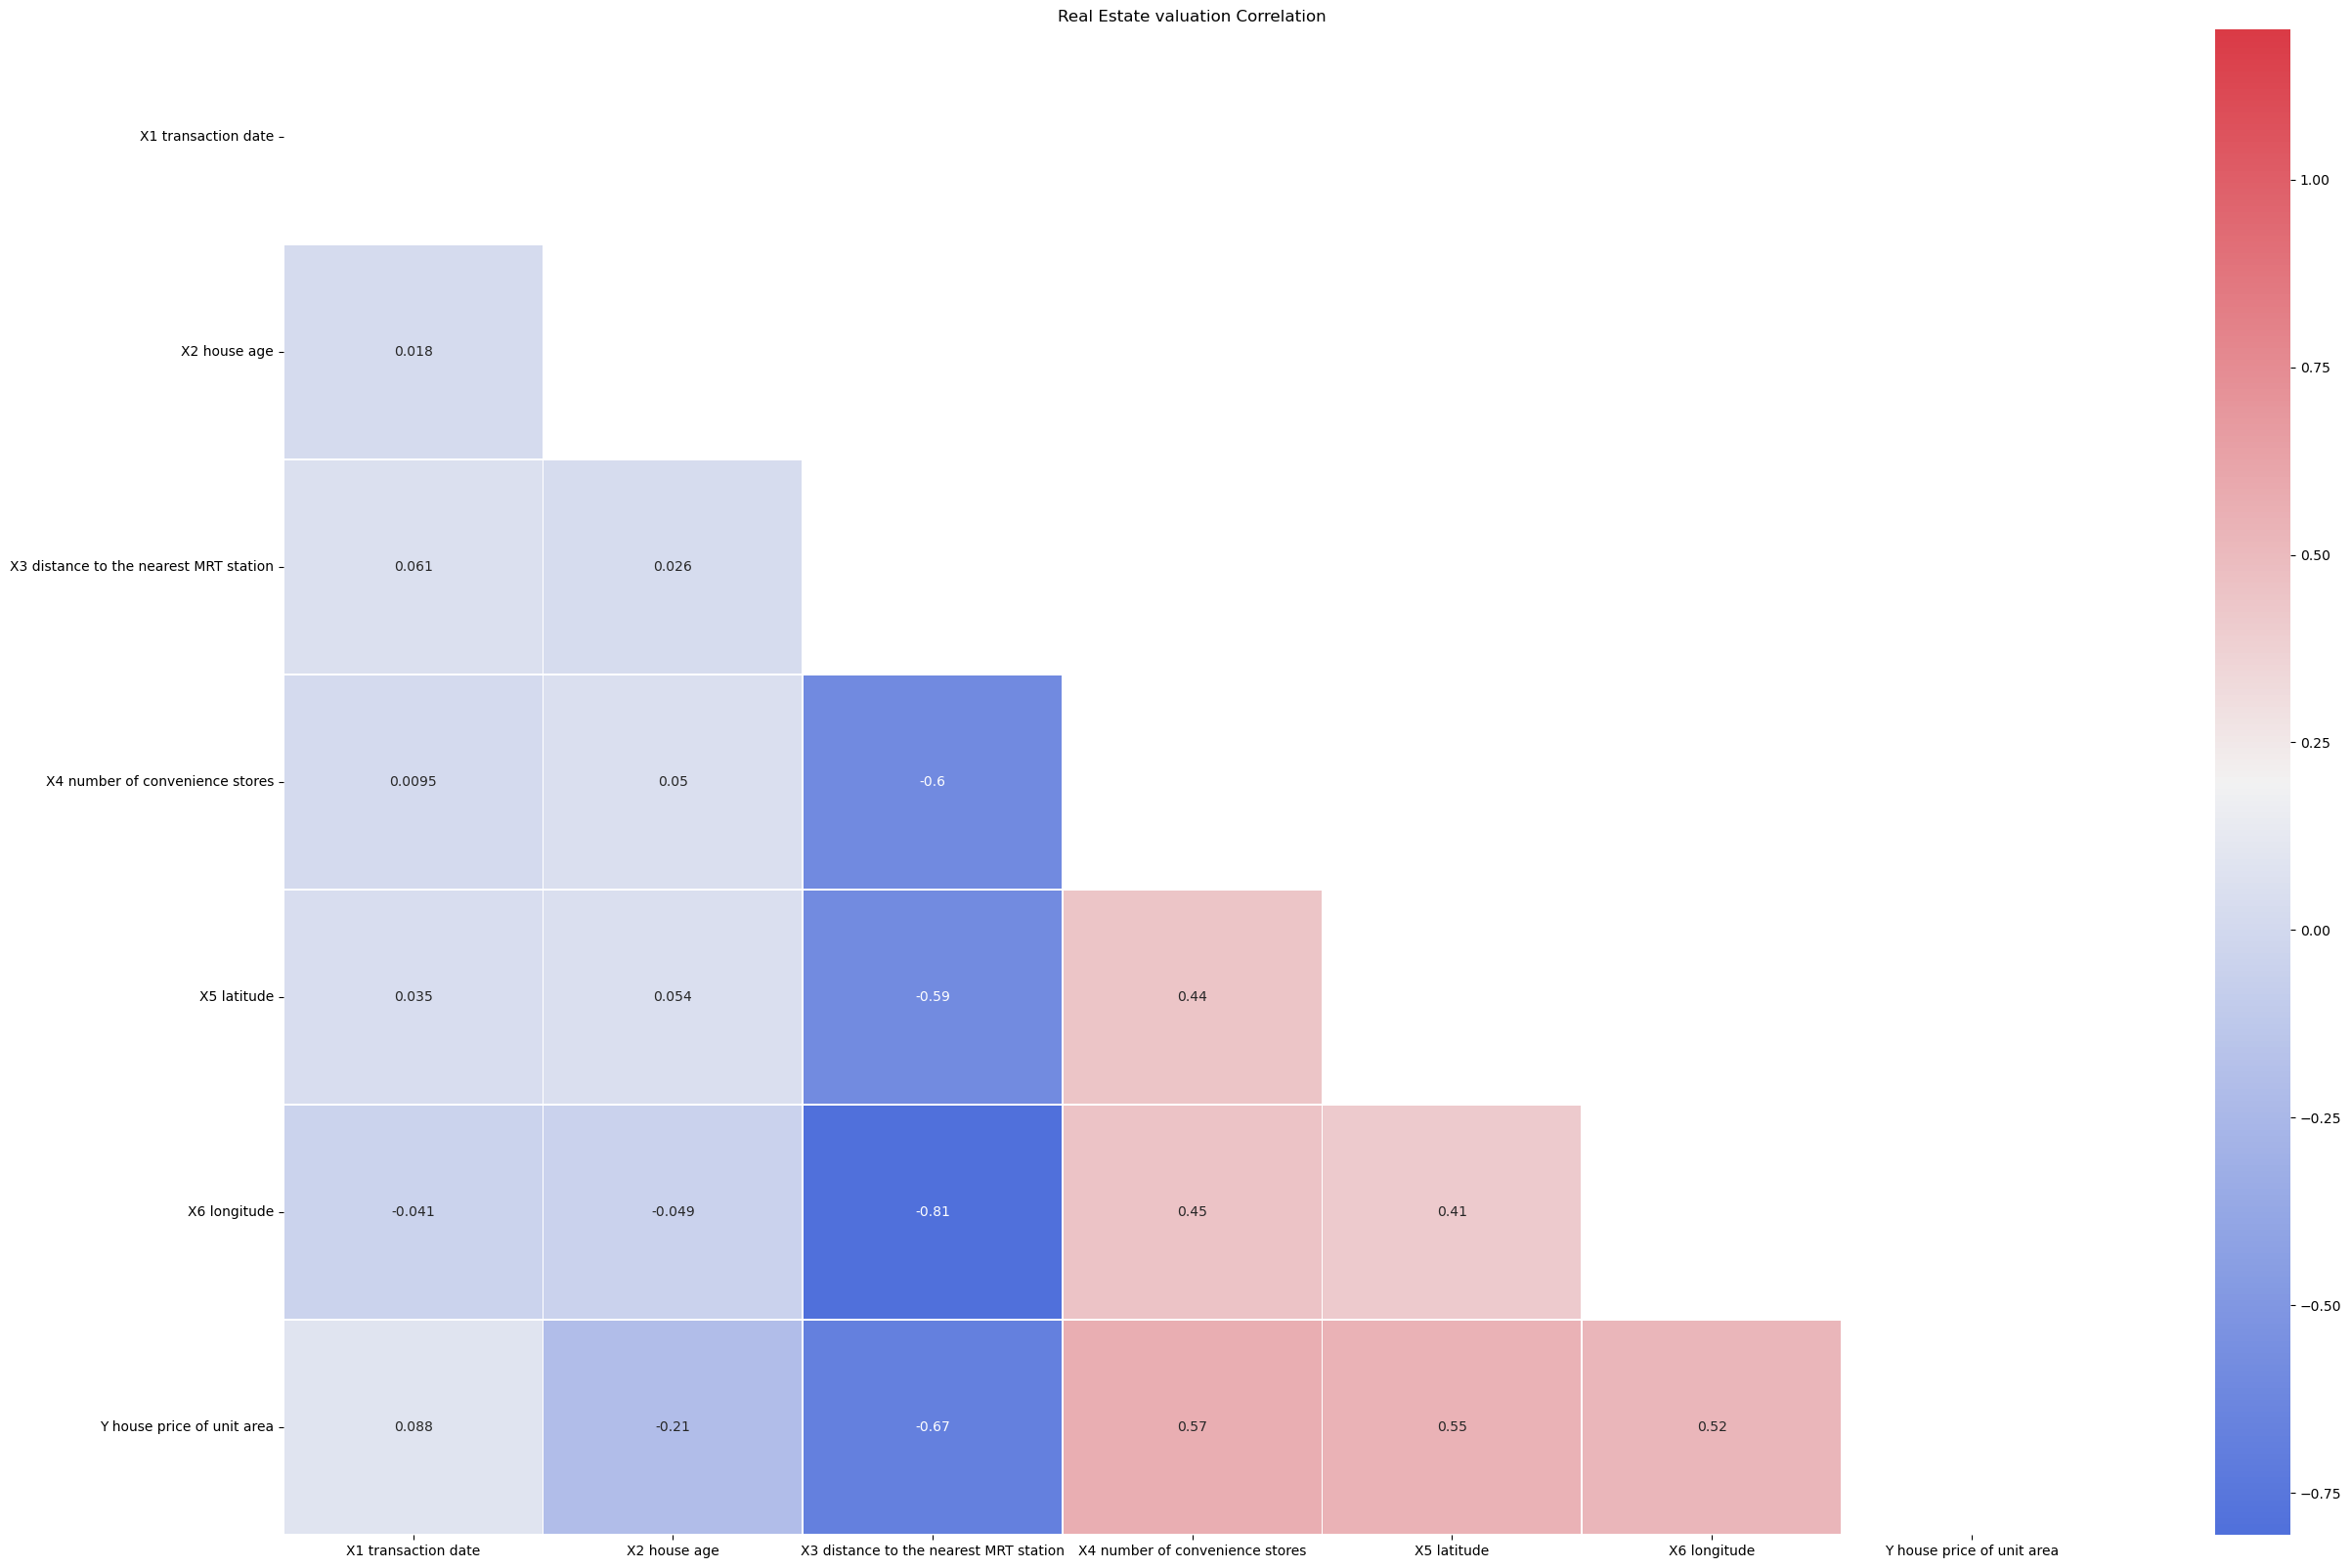

In [29]:
corrMatt = all_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

In [30]:
Xs = all_df.drop("Y house price of unit area",axis=1)
target = all_df['Y house price of unit area']

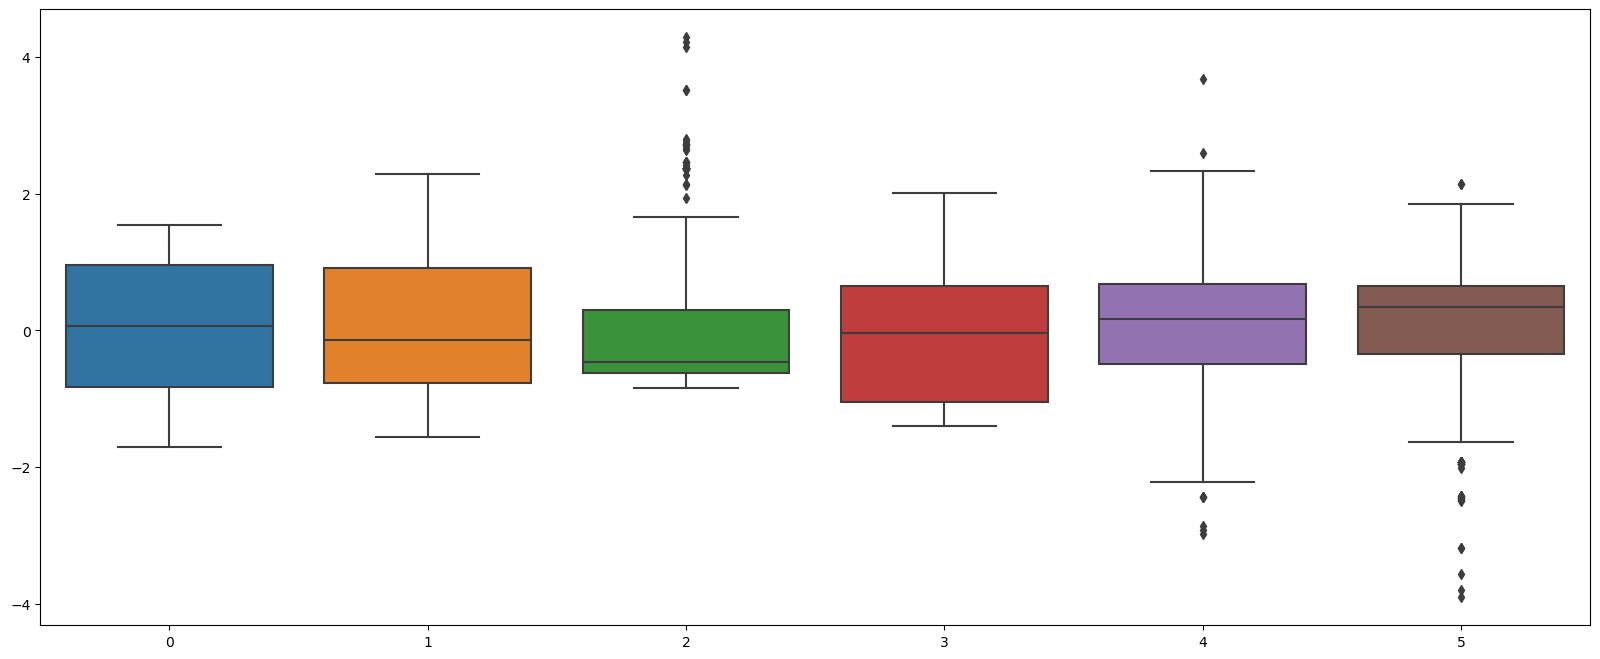

In [31]:
scaler = StandardScaler()
features = scaler.fit_transform(Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [33]:
#define currency conversion
def curr_conversion(score):
    result = np.sqrt(score)
    result = result/3.3
    result = result/37
    return result

### 2. Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
cv_error = np.average(cross_val_score(clf, features, target, scoring = 'neg_mean_squared_error')) * (-1)
print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation MSE score for this classifier is 80.64


In [35]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(cv_error)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.07355


### 3. SVM

In [36]:
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVR(kernel="rbf", gamma='auto')

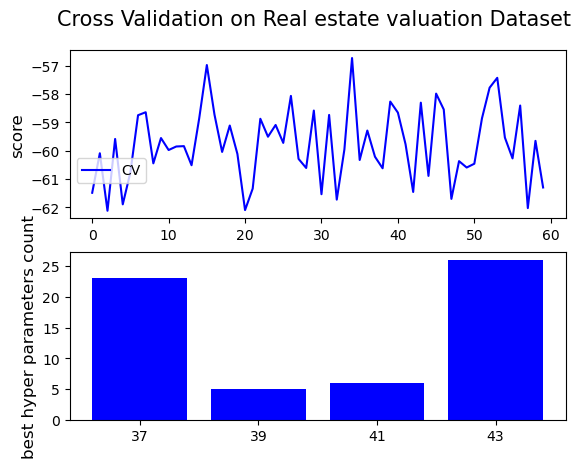

In [37]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [37,39,41,43]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error')
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-37)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Real estate valuation Dataset ",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[37,39,41,43])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

In [38]:
svm = SVR(C = 37,kernel="rbf", gamma='auto')
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_squared_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this classifier is 59.02


In [39]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.06292


### 4. Decision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [41]:
tree_dtr = tree.DecisionTreeRegressor()

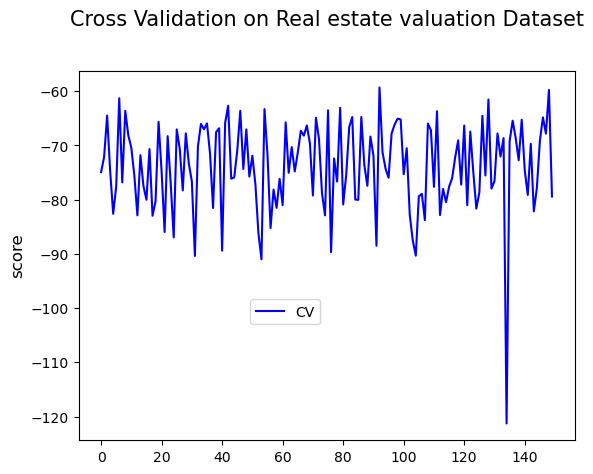

In [42]:
from sklearn.model_selection import KFold

NUM_TRIALS = 150

X = features
y = target

p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}
scores = np.zeros(NUM_TRIALS)
params = []
for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    dtr = GridSearchCV(estimator=tree_dtr, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error')
    dtr.fit(X,y)
    scores[i] = dtr.best_score_
    params.append(dtr.best_params_)
    best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
    
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Real estate valuation Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

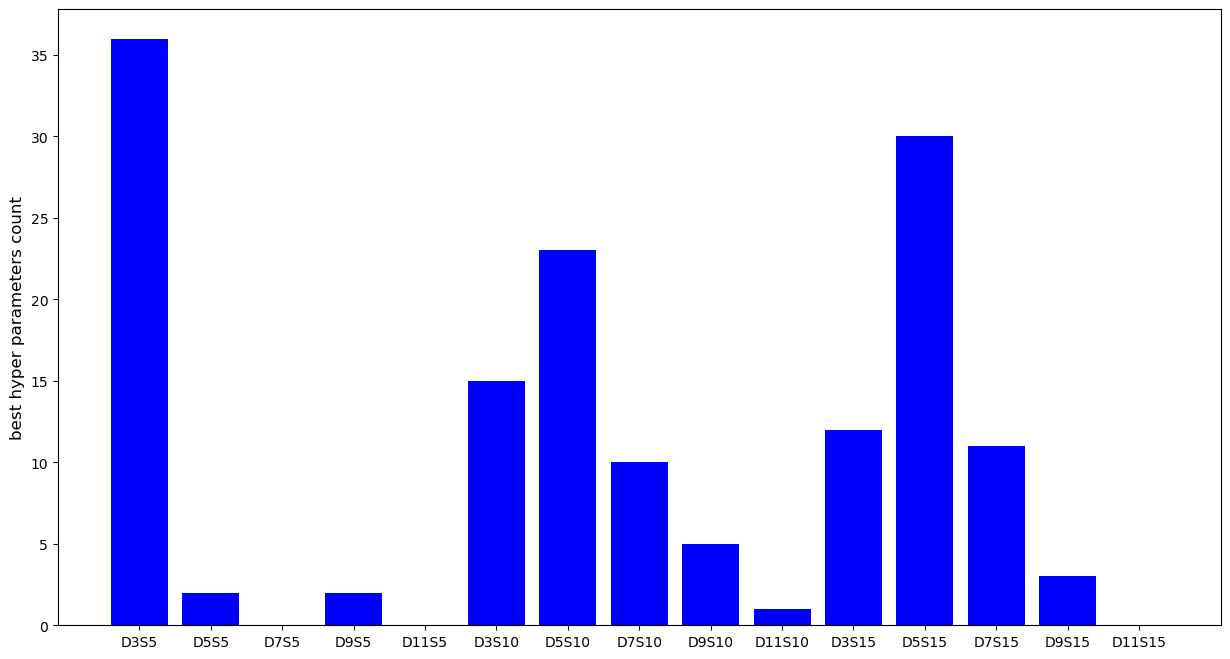

In [43]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

From the cross validation above, we can see that __max_depth = 3__ and __min_samples_split = 5__ give the best result.

In [44]:
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 5)

cv_error_array = cross_val_score(tree_reg, features, target, scoring='neg_mean_squared_error') * (-1)

average = np.average(cv_error_array)

print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this classifier is 77.17


In [45]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.07194


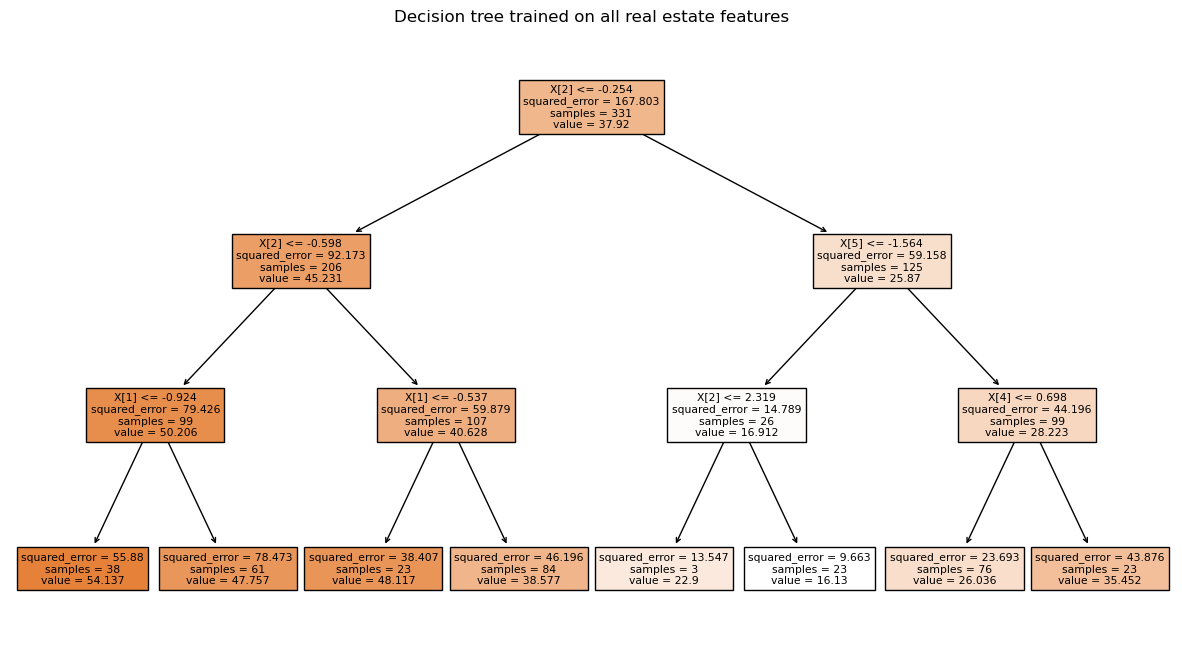

In [46]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_reg.fit(x_train, y_train), filled=True)
plt.title("Decision tree trained on all real estate features")
plt.show()

### 5. ANN

In [47]:
from tensorflow import keras

model = keras.models.Sequential()  
model.add(keras.layers.Dense(units = 8, activation='relu', input_shape=(x_train.shape[1],)))
    
model.add(keras.layers.Dense(units = 1, activation='linear'))  
    
print(model.summary())  
    
model.compile(loss='mse',optimizer='sgd',  metrics=[keras.metrics.MeanSquaredError()])  

kf = KFold(n_splits=5)
k=1
    
all_score = []

for train_index, test_index in kf.split(features):
    print("fold",k)
    # Split the data
    X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
    y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        
    # training and validation
    model.fit(np.array(X_train), np.array(y_train), epochs=200, batch_size=200, verbose=2, validation_data=(np.array(X_test), np.array(y_test)))

    # evaluate the accuracy of each fold
    scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
    
    print("%s: %.2f" % (model.metrics_names[1], scores[1]))
    k = k+1
    all_score.append(scores[1])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
fold 1
Train on 331 samples, validate on 83 samples
Epoch 1/200
331/331 - 0s - loss: 1540.8349 - mean_squared_error: 1540.8350 - val_loss: 1279.9801 - val_mean_squared_error: 1279.9801
Epoch 2/200
331/331 - 0s - loss: 1086.6843 - mean_squared_error: 1086.6843 - val_loss: 293.7266 - val_mean_squared_error: 293.7266
Epoch 3/200
331/331 - 0s - loss: 247.6590 - mean_squared_error: 247.6590 - val_loss: 73.7258 - val_mean_squared_error: 73.7258
Epoch 4/200
331/331 - 0s - loss: 95.6943 - mean_squared_error: 95.6943 -

Epoch 61/200
331/331 - 0s - loss: 60.1869 - mean_squared_error: 60.1869 - val_loss: 49.8659 - val_mean_squared_error: 49.8659
Epoch 62/200
331/331 - 0s - loss: 59.9497 - mean_squared_error: 59.9497 - val_loss: 47.0661 - val_mean_squared_error: 47.0661
Epoch 63/200
331/331 - 0s - loss: 61.5407 - mean_squared_error: 61.5407 - val_loss: 50.5068 - val_mean_squared_error: 50.5068
Epoch 64/200
331/331 - 0s - loss: 61.8050 - mean_squared_error: 61.8049 - val_loss: 47.5742 - val_mean_squared_error: 47.5742
Epoch 65/200
331/331 - 0s - loss: 59.0616 - mean_squared_error: 59.0616 - val_loss: 48.8927 - val_mean_squared_error: 48.8927
Epoch 66/200
331/331 - 0s - loss: 59.8369 - mean_squared_error: 59.8369 - val_loss: 45.3934 - val_mean_squared_error: 45.3934
Epoch 67/200
331/331 - 0s - loss: 60.0954 - mean_squared_error: 60.0954 - val_loss: 48.6985 - val_mean_squared_error: 48.6985
Epoch 68/200
331/331 - 0s - loss: 60.9718 - mean_squared_error: 60.9718 - val_loss: 47.0238 - val_mean_squared_error: 

Epoch 126/200
331/331 - 0s - loss: 56.9157 - mean_squared_error: 56.9157 - val_loss: 45.4605 - val_mean_squared_error: 45.4605
Epoch 127/200
331/331 - 0s - loss: 58.4715 - mean_squared_error: 58.4715 - val_loss: 45.5463 - val_mean_squared_error: 45.5463
Epoch 128/200
331/331 - 0s - loss: 59.0881 - mean_squared_error: 59.0881 - val_loss: 47.3522 - val_mean_squared_error: 47.3522
Epoch 129/200
331/331 - 0s - loss: 58.6505 - mean_squared_error: 58.6505 - val_loss: 47.2031 - val_mean_squared_error: 47.2031
Epoch 130/200
331/331 - 0s - loss: 57.4889 - mean_squared_error: 57.4889 - val_loss: 46.7328 - val_mean_squared_error: 46.7328
Epoch 131/200
331/331 - 0s - loss: 56.6258 - mean_squared_error: 56.6258 - val_loss: 44.5528 - val_mean_squared_error: 44.5528
Epoch 132/200
331/331 - 0s - loss: 57.8155 - mean_squared_error: 57.8155 - val_loss: 45.4246 - val_mean_squared_error: 45.4246
Epoch 133/200
331/331 - 0s - loss: 57.7258 - mean_squared_error: 57.7258 - val_loss: 46.7530 - val_mean_squared

Epoch 191/200
331/331 - 0s - loss: 56.3216 - mean_squared_error: 56.3216 - val_loss: 46.2288 - val_mean_squared_error: 46.2288
Epoch 192/200
331/331 - 0s - loss: 57.4833 - mean_squared_error: 57.4833 - val_loss: 45.3135 - val_mean_squared_error: 45.3135
Epoch 193/200
331/331 - 0s - loss: 59.8462 - mean_squared_error: 59.8463 - val_loss: 52.3754 - val_mean_squared_error: 52.3754
Epoch 194/200
331/331 - 0s - loss: 60.6530 - mean_squared_error: 60.6530 - val_loss: 46.2126 - val_mean_squared_error: 46.2126
Epoch 195/200
331/331 - 0s - loss: 57.0471 - mean_squared_error: 57.0471 - val_loss: 45.0037 - val_mean_squared_error: 45.0037
Epoch 196/200
331/331 - 0s - loss: 56.7472 - mean_squared_error: 56.7472 - val_loss: 45.9900 - val_mean_squared_error: 45.9900
Epoch 197/200
331/331 - 0s - loss: 62.5071 - mean_squared_error: 62.5071 - val_loss: 62.2406 - val_mean_squared_error: 62.2406
Epoch 198/200
331/331 - 0s - loss: 76.7537 - mean_squared_error: 76.7537 - val_loss: 63.9379 - val_mean_squared

Epoch 55/200
331/331 - 0s - loss: 46.8559 - mean_squared_error: 46.8559 - val_loss: 116.5478 - val_mean_squared_error: 116.5478
Epoch 56/200
331/331 - 0s - loss: 51.6547 - mean_squared_error: 51.6547 - val_loss: 125.9957 - val_mean_squared_error: 125.9957
Epoch 57/200
331/331 - 0s - loss: 47.6615 - mean_squared_error: 47.6615 - val_loss: 108.5907 - val_mean_squared_error: 108.5907
Epoch 58/200
331/331 - 0s - loss: 38.2606 - mean_squared_error: 38.2606 - val_loss: 112.4448 - val_mean_squared_error: 112.4448
Epoch 59/200
331/331 - 0s - loss: 39.0173 - mean_squared_error: 39.0173 - val_loss: 112.4414 - val_mean_squared_error: 112.4414
Epoch 60/200
331/331 - 0s - loss: 38.6431 - mean_squared_error: 38.6431 - val_loss: 110.3350 - val_mean_squared_error: 110.3350
Epoch 61/200
331/331 - 0s - loss: 38.5486 - mean_squared_error: 38.5486 - val_loss: 110.0627 - val_mean_squared_error: 110.0627
Epoch 62/200
331/331 - 0s - loss: 37.8950 - mean_squared_error: 37.8950 - val_loss: 109.8962 - val_mean_

Epoch 119/200
331/331 - 0s - loss: 36.7448 - mean_squared_error: 36.7448 - val_loss: 112.6245 - val_mean_squared_error: 112.6245
Epoch 120/200
331/331 - 0s - loss: 36.9796 - mean_squared_error: 36.9796 - val_loss: 110.8318 - val_mean_squared_error: 110.8318
Epoch 121/200
331/331 - 0s - loss: 37.1425 - mean_squared_error: 37.1425 - val_loss: 113.9167 - val_mean_squared_error: 113.9167
Epoch 122/200
331/331 - 0s - loss: 40.1561 - mean_squared_error: 40.1561 - val_loss: 114.3059 - val_mean_squared_error: 114.3059
Epoch 123/200
331/331 - 0s - loss: 38.8320 - mean_squared_error: 38.8320 - val_loss: 112.9218 - val_mean_squared_error: 112.9218
Epoch 124/200
331/331 - 0s - loss: 36.5660 - mean_squared_error: 36.5660 - val_loss: 110.3766 - val_mean_squared_error: 110.3766
Epoch 125/200
331/331 - 0s - loss: 36.7013 - mean_squared_error: 36.7013 - val_loss: 110.9524 - val_mean_squared_error: 110.9524
Epoch 126/200
331/331 - 0s - loss: 38.5512 - mean_squared_error: 38.5512 - val_loss: 111.3366 - v

Epoch 183/200
331/331 - 0s - loss: 40.3254 - mean_squared_error: 40.3254 - val_loss: 115.2894 - val_mean_squared_error: 115.2894
Epoch 184/200
331/331 - 0s - loss: 37.5872 - mean_squared_error: 37.5872 - val_loss: 112.9650 - val_mean_squared_error: 112.9650
Epoch 185/200
331/331 - 0s - loss: 36.3893 - mean_squared_error: 36.3893 - val_loss: 113.2494 - val_mean_squared_error: 113.2494
Epoch 186/200
331/331 - 0s - loss: 36.6906 - mean_squared_error: 36.6906 - val_loss: 112.8459 - val_mean_squared_error: 112.8459
Epoch 187/200
331/331 - 0s - loss: 34.8821 - mean_squared_error: 34.8821 - val_loss: 112.5252 - val_mean_squared_error: 112.5252
Epoch 188/200
331/331 - 0s - loss: 34.8806 - mean_squared_error: 34.8806 - val_loss: 112.5218 - val_mean_squared_error: 112.5218
Epoch 189/200
331/331 - 0s - loss: 35.2256 - mean_squared_error: 35.2256 - val_loss: 113.0585 - val_mean_squared_error: 113.0585
Epoch 190/200
331/331 - 0s - loss: 36.1202 - mean_squared_error: 36.1202 - val_loss: 116.4579 - v

Epoch 48/200
331/331 - 0s - loss: 52.3243 - mean_squared_error: 52.3243 - val_loss: 43.5804 - val_mean_squared_error: 43.5804
Epoch 49/200
331/331 - 0s - loss: 57.7815 - mean_squared_error: 57.7815 - val_loss: 45.9562 - val_mean_squared_error: 45.9562
Epoch 50/200
331/331 - 0s - loss: 54.9742 - mean_squared_error: 54.9743 - val_loss: 42.8122 - val_mean_squared_error: 42.8122
Epoch 51/200
331/331 - 0s - loss: 51.3479 - mean_squared_error: 51.3479 - val_loss: 43.0328 - val_mean_squared_error: 43.0328
Epoch 52/200
331/331 - 0s - loss: 50.4959 - mean_squared_error: 50.4959 - val_loss: 43.4701 - val_mean_squared_error: 43.4701
Epoch 53/200
331/331 - 0s - loss: 51.0323 - mean_squared_error: 51.0323 - val_loss: 42.4629 - val_mean_squared_error: 42.4629
Epoch 54/200
331/331 - 0s - loss: 57.2526 - mean_squared_error: 57.2526 - val_loss: 49.2684 - val_mean_squared_error: 49.2684
Epoch 55/200
331/331 - 0s - loss: 60.9935 - mean_squared_error: 60.9935 - val_loss: 43.3613 - val_mean_squared_error: 

Epoch 113/200
331/331 - 0s - loss: 49.5689 - mean_squared_error: 49.5689 - val_loss: 46.2859 - val_mean_squared_error: 46.2859
Epoch 114/200
331/331 - 0s - loss: 51.2184 - mean_squared_error: 51.2184 - val_loss: 52.9899 - val_mean_squared_error: 52.9899
Epoch 115/200
331/331 - 0s - loss: 50.1472 - mean_squared_error: 50.1472 - val_loss: 43.5888 - val_mean_squared_error: 43.5888
Epoch 116/200
331/331 - 0s - loss: 49.4590 - mean_squared_error: 49.4590 - val_loss: 47.4130 - val_mean_squared_error: 47.4130
Epoch 117/200
331/331 - 0s - loss: 50.1500 - mean_squared_error: 50.1500 - val_loss: 45.1646 - val_mean_squared_error: 45.1646
Epoch 118/200
331/331 - 0s - loss: 49.6683 - mean_squared_error: 49.6683 - val_loss: 50.4362 - val_mean_squared_error: 50.4362
Epoch 119/200
331/331 - 0s - loss: 53.5599 - mean_squared_error: 53.5599 - val_loss: 54.2946 - val_mean_squared_error: 54.2946
Epoch 120/200
331/331 - 0s - loss: 53.4852 - mean_squared_error: 53.4852 - val_loss: 48.2670 - val_mean_squared

Epoch 178/200
331/331 - 0s - loss: 50.1523 - mean_squared_error: 50.1523 - val_loss: 43.9133 - val_mean_squared_error: 43.9133
Epoch 179/200
331/331 - 0s - loss: 50.7605 - mean_squared_error: 50.7605 - val_loss: 45.3584 - val_mean_squared_error: 45.3584
Epoch 180/200
331/331 - 0s - loss: 51.8189 - mean_squared_error: 51.8189 - val_loss: 47.4438 - val_mean_squared_error: 47.4438
Epoch 181/200
331/331 - 0s - loss: 57.6478 - mean_squared_error: 57.6478 - val_loss: 45.7100 - val_mean_squared_error: 45.7100
Epoch 182/200
331/331 - 0s - loss: 56.3192 - mean_squared_error: 56.3191 - val_loss: 46.4379 - val_mean_squared_error: 46.4379
Epoch 183/200
331/331 - 0s - loss: 54.9457 - mean_squared_error: 54.9457 - val_loss: 44.9570 - val_mean_squared_error: 44.9570
Epoch 184/200
331/331 - 0s - loss: 54.4938 - mean_squared_error: 54.4938 - val_loss: 47.8819 - val_mean_squared_error: 47.8819
Epoch 185/200
331/331 - 0s - loss: 53.8300 - mean_squared_error: 53.8300 - val_loss: 45.0602 - val_mean_squared

Epoch 43/200
331/331 - 0s - loss: 52.6427 - mean_squared_error: 52.6427 - val_loss: 39.3206 - val_mean_squared_error: 39.3206
Epoch 44/200
331/331 - 0s - loss: 51.1309 - mean_squared_error: 51.1309 - val_loss: 38.0252 - val_mean_squared_error: 38.0252
Epoch 45/200
331/331 - 0s - loss: 51.4781 - mean_squared_error: 51.4781 - val_loss: 42.8768 - val_mean_squared_error: 42.8768
Epoch 46/200
331/331 - 0s - loss: 52.5645 - mean_squared_error: 52.5645 - val_loss: 38.7350 - val_mean_squared_error: 38.7350
Epoch 47/200
331/331 - 0s - loss: 50.9958 - mean_squared_error: 50.9958 - val_loss: 39.0925 - val_mean_squared_error: 39.0925
Epoch 48/200
331/331 - 0s - loss: 52.3402 - mean_squared_error: 52.3402 - val_loss: 40.9503 - val_mean_squared_error: 40.9503
Epoch 49/200
331/331 - 0s - loss: 51.3915 - mean_squared_error: 51.3915 - val_loss: 37.9633 - val_mean_squared_error: 37.9633
Epoch 50/200
331/331 - 0s - loss: 50.6919 - mean_squared_error: 50.6919 - val_loss: 38.4755 - val_mean_squared_error: 

Epoch 108/200
331/331 - 0s - loss: 51.5520 - mean_squared_error: 51.5520 - val_loss: 40.2945 - val_mean_squared_error: 40.2945
Epoch 109/200
331/331 - 0s - loss: 51.2878 - mean_squared_error: 51.2878 - val_loss: 41.7039 - val_mean_squared_error: 41.7039
Epoch 110/200
331/331 - 0s - loss: 50.7198 - mean_squared_error: 50.7198 - val_loss: 37.2711 - val_mean_squared_error: 37.2711
Epoch 111/200
331/331 - 0s - loss: 51.4423 - mean_squared_error: 51.4423 - val_loss: 36.1039 - val_mean_squared_error: 36.1039
Epoch 112/200
331/331 - 0s - loss: 52.0256 - mean_squared_error: 52.0256 - val_loss: 37.6080 - val_mean_squared_error: 37.6080
Epoch 113/200
331/331 - 0s - loss: 53.0813 - mean_squared_error: 53.0813 - val_loss: 38.9178 - val_mean_squared_error: 38.9178
Epoch 114/200
331/331 - 0s - loss: 52.6513 - mean_squared_error: 52.6513 - val_loss: 37.0500 - val_mean_squared_error: 37.0500
Epoch 115/200
331/331 - 0s - loss: 51.9656 - mean_squared_error: 51.9656 - val_loss: 38.8688 - val_mean_squared

Epoch 173/200
331/331 - 0s - loss: 50.3945 - mean_squared_error: 50.3945 - val_loss: 40.8290 - val_mean_squared_error: 40.8290
Epoch 174/200
331/331 - 0s - loss: 50.2003 - mean_squared_error: 50.2003 - val_loss: 38.0839 - val_mean_squared_error: 38.0839
Epoch 175/200
331/331 - 0s - loss: 50.4038 - mean_squared_error: 50.4038 - val_loss: 38.6102 - val_mean_squared_error: 38.6102
Epoch 176/200
331/331 - 0s - loss: 50.8989 - mean_squared_error: 50.8989 - val_loss: 39.0604 - val_mean_squared_error: 39.0604
Epoch 177/200
331/331 - 0s - loss: 51.5273 - mean_squared_error: 51.5273 - val_loss: 41.7426 - val_mean_squared_error: 41.7426
Epoch 178/200
331/331 - 0s - loss: 50.7388 - mean_squared_error: 50.7388 - val_loss: 43.2864 - val_mean_squared_error: 43.2864
Epoch 179/200
331/331 - 0s - loss: 52.6866 - mean_squared_error: 52.6866 - val_loss: 41.9142 - val_mean_squared_error: 41.9142
Epoch 180/200
331/331 - 0s - loss: 50.8277 - mean_squared_error: 50.8277 - val_loss: 40.7623 - val_mean_squared

Epoch 38/200
332/332 - 0s - loss: 51.1682 - mean_squared_error: 51.1682 - val_loss: 42.6731 - val_mean_squared_error: 42.6731
Epoch 39/200
332/332 - 0s - loss: 49.8150 - mean_squared_error: 49.8150 - val_loss: 45.0839 - val_mean_squared_error: 45.0839
Epoch 40/200
332/332 - 0s - loss: 49.1619 - mean_squared_error: 49.1619 - val_loss: 42.0800 - val_mean_squared_error: 42.0800
Epoch 41/200
332/332 - 0s - loss: 50.5622 - mean_squared_error: 50.5622 - val_loss: 42.5647 - val_mean_squared_error: 42.5647
Epoch 42/200
332/332 - 0s - loss: 49.2928 - mean_squared_error: 49.2928 - val_loss: 42.3072 - val_mean_squared_error: 42.3072
Epoch 43/200
332/332 - 0s - loss: 48.9709 - mean_squared_error: 48.9709 - val_loss: 40.8875 - val_mean_squared_error: 40.8875
Epoch 44/200
332/332 - 0s - loss: 49.0455 - mean_squared_error: 49.0455 - val_loss: 40.7122 - val_mean_squared_error: 40.7122
Epoch 45/200
332/332 - 0s - loss: 48.8202 - mean_squared_error: 48.8202 - val_loss: 42.9104 - val_mean_squared_error: 

Epoch 103/200
332/332 - 0s - loss: 58.0612 - mean_squared_error: 58.0612 - val_loss: 64.3343 - val_mean_squared_error: 64.3343
Epoch 104/200
332/332 - 0s - loss: 63.6240 - mean_squared_error: 63.6240 - val_loss: 67.7100 - val_mean_squared_error: 67.7100
Epoch 105/200
332/332 - 0s - loss: 63.0888 - mean_squared_error: 63.0888 - val_loss: 55.6661 - val_mean_squared_error: 55.6661
Epoch 106/200
332/332 - 0s - loss: 53.2236 - mean_squared_error: 53.2236 - val_loss: 51.4434 - val_mean_squared_error: 51.4434
Epoch 107/200
332/332 - 0s - loss: 49.5754 - mean_squared_error: 49.5754 - val_loss: 43.6933 - val_mean_squared_error: 43.6933
Epoch 108/200
332/332 - 0s - loss: 49.2130 - mean_squared_error: 49.2130 - val_loss: 53.2423 - val_mean_squared_error: 53.2423
Epoch 109/200
332/332 - 0s - loss: 50.0880 - mean_squared_error: 50.0880 - val_loss: 45.4225 - val_mean_squared_error: 45.4225
Epoch 110/200
332/332 - 0s - loss: 48.3922 - mean_squared_error: 48.3922 - val_loss: 42.2497 - val_mean_squared

Epoch 168/200
332/332 - 0s - loss: 55.6112 - mean_squared_error: 55.6112 - val_loss: 45.3960 - val_mean_squared_error: 45.3960
Epoch 169/200
332/332 - 0s - loss: 55.1435 - mean_squared_error: 55.1435 - val_loss: 45.4275 - val_mean_squared_error: 45.4275
Epoch 170/200
332/332 - 0s - loss: 54.9179 - mean_squared_error: 54.9179 - val_loss: 45.9515 - val_mean_squared_error: 45.9515
Epoch 171/200
332/332 - 0s - loss: 64.3853 - mean_squared_error: 64.3853 - val_loss: 53.8194 - val_mean_squared_error: 53.8194
Epoch 172/200
332/332 - 0s - loss: 65.8816 - mean_squared_error: 65.8816 - val_loss: 45.4690 - val_mean_squared_error: 45.4690
Epoch 173/200
332/332 - 0s - loss: 51.4165 - mean_squared_error: 51.4165 - val_loss: 44.5534 - val_mean_squared_error: 44.5534
Epoch 174/200
332/332 - 0s - loss: 51.3777 - mean_squared_error: 51.3777 - val_loss: 49.7009 - val_mean_squared_error: 49.7009
Epoch 175/200
332/332 - 0s - loss: 63.8866 - mean_squared_error: 63.8866 - val_loss: 44.4679 - val_mean_squared

In [48]:
print(all_score)

[44.203903, 114.123116, 44.40921, 37.331333, 44.102257]


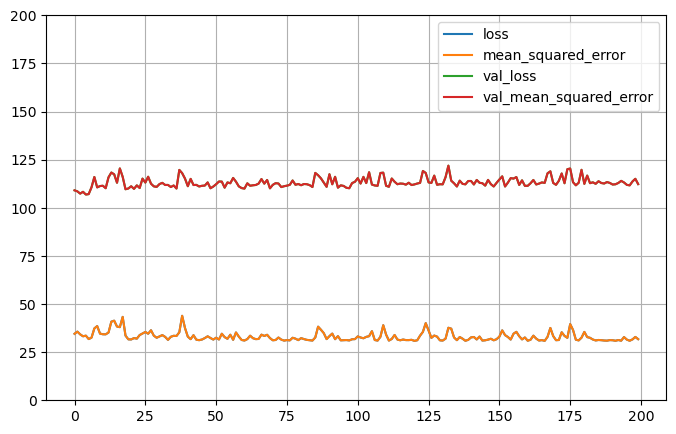

In [49]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

history = model.fit(x_train, y_train, epochs=200, batch_size=200, verbose=0, validation_data = (x_test, y_test))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 200) # set the vertical range to [0-1]
plt.show()